# Group-based Classification Models

### Importing libraries and define functions

In [1]:
import pandas as pd
import numpy as np
import scipy
import math
import os
import sys

In [2]:
# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [3]:
import sklearn
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

In [4]:
from pycaret.classification import *

In [5]:
import functions as f

# Metal Oxide classification model

In [6]:
model_name = "oxide"
group_name = "meta_oxide"
seed = 123

### Load the data and filter instances

In [7]:
data_train_df = pd.read_csv("output/datasets/universal/data_classification_train_df.csv", encoding="utf-8")
data_test_df = pd.read_csv("output/datasets/universal/data_classification_test_df.csv", encoding="utf-8")
data_df = pd.concat([data_train_df,data_test_df])

del data_train_df
del data_test_df

In [8]:
data_df.shape

(11315, 20)

In [9]:
data_group_df = data_df[data_df['nanomaterial_group'] == group_name]

In [10]:
data_group_df.shape

(4082, 20)

In [11]:
data_group_df.head()

,NP_type,Coating,core_size_nm,hydro_size_nm,Surf_charge_mV,Surface_area_m2_g,shape,Dose_microg_mL,Duration_h,Cell_name,Cell_species,cell_Organ,Cell_morphology,Cell_age,cell_type,sex,Assay,Test_indicator,nanomaterial_group,viability_class
1,TiO2,None,10.0,1457.0,-11.00,NaN,NaN,10.0,NaN,BEAS_2B,Human,Lung,Epithelial,Adult,Normal,NaN,MTS,TetrazoliumSalt,meta_oxide,NonToxic
4,TiO2,None,5.0,NaN,NaN,NaN,Lentil,10.0,24.0,SH­SY5Y,Human,BoneMarrow,Epithelial,Young,cancer,female,MTT,TetrazoliumSalt,meta_oxide,NonToxic
8,SiO2,None,50.0,79.0,-13.20,108.3,NaN,10.0,24.0,A549,Human,Lung,Epithelial,Adult,cancer,male,Alamar_Blue,AlamarBlue,meta_oxide,NonToxic
12,TiO2,None,38.0,NaN,NaN,NaN,NaN,0.0,24.0,HUVEC,Human,Umbilical,Endothelial,fetus,Normal,NaN,CytoTox­One,LDHrelease,meta_oxide,NonToxic
20,Bi2O3,None,27.4,515.6,18.12,NaN,Tetragonal,6.2,24.0,THP_1,Human,Blood,monocyte,neonate,cancer,male,MTS,TetrazoliumSalt,meta_oxide,NonToxic


### Create training set and test set

In [12]:
splitter = setup(data = data_group_df, target = 'viability_class',
                 preprocess = False,
                 train_size=0.8,
                 data_split_stratify=True,
                 # don't change the following
                 session_id = seed,
                 use_gpu=False,
                 log_experiment = False,
                 silent=True,
                 experiment_name = 'splitter')

,Description,Value
0,session_id,123
1,Target,viability_class
2,Target Type,Binary
3,Label Encoded,"NonToxic: 0, Toxic: 1"
4,Original Data,"(4082, 20)"
5,Missing Values,True
6,Numeric Features,6
7,Categorical Features,13
8,Transformed Train Set,"(3265, 19)"
9,Transformed Test Set,"(817, 19)"


In [13]:
data_group_train_df = get_config(variable="X_train").copy()
data_group_train_df['viability_class'] = get_config(variable="y_train").copy()

data_group_test_df = get_config(variable="X_test").copy()
data_group_test_df['viability_class'] = get_config(variable="y_test").copy()

In [14]:
print(data_group_train_df.shape)
print(data_group_test_df.shape)

(3265, 20)
(817, 20)


In [15]:
print(data_group_train_df['viability_class'].value_counts())
print(data_group_test_df['viability_class'].value_counts())

0    2646
1     619
Name: viability_class, dtype: int64
0    662
1    155
Name: viability_class, dtype: int64


### Save cleaned datasets

In [16]:
data_group_train_df.to_csv('output/datasets/'+model_name+'/data_classification_'+model_name+'_train_df.csv', encoding='utf-8', index=False)

In [17]:
data_group_test_df.to_csv('output/datasets/'+model_name+'/data_classification_'+model_name+'_test_df.csv', encoding='utf-8', index=False)

### Use the best scenario identified in step 01

In [18]:
sc_ignore_features = ['nanomaterial_group', 'Coating', 'Cell_name']
sc_bin_numeric_features = None
sc_high_cardinality_features = None

sc_imputation_type = 'iterative'
sc_numeric_imputation = 'mean'

sc_normalize = True
sc_remove_outliers = True

### Data Preprcoessing

In [19]:
stup = setup(data = data_group_train_df, target = 'viability_class', 
              
        test_data = data_group_test_df,

        imputation_type = sc_imputation_type, 
        numeric_imputation = sc_numeric_imputation, #default: mean

        categorical_imputation = "constant", #default: constant
        iterative_imputation_iters = 5, #default: 5
        numeric_iterative_imputer = "lightgbm",
        categorical_iterative_imputer = "lightgbm",

        ignore_features = sc_ignore_features,
        bin_numeric_features = sc_bin_numeric_features,
        high_cardinality_features = sc_high_cardinality_features,

        high_cardinality_method = "frequency", #default: frequency
        handle_unknown_categorical = True, #default
        unknown_categorical_method = "least_frequent", #default

        normalize = sc_normalize, #default: False
        remove_outliers= sc_remove_outliers, #default: False

        outliers_threshold = 0.05, #default

        transformation= False, #default
        transformation_method = 'yeo-johnson', #default
        combine_rare_levels = False,
        rare_level_threshold = 0.1, #default: 0.1

        remove_multicollinearity = False, #default 
        multicollinearity_threshold = 0.9, #default

        ignore_low_variance = True, 

        feature_interaction = False, 
        feature_ratio = False,
        polynomial_features = False, 
        trigonometry_features = False,

        fix_imbalance = True,
        #fix_imbalance_method = SMOTE, # default
        
        # don't change the following
        session_id = seed,
        use_gpu=False,
        log_experiment = False,
        silent=True,
        experiment_name = model_name)

set_config('seed', seed)

,Description,Value
0,session_id,123
1,Target,viability_class
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(3265, 20)"
5,Missing Values,True
6,Numeric Features,6
7,Categorical Features,10
8,Ordinal Features,False
9,High Cardinality Features,False


In [20]:
print(get_config(variable="X_train").shape)
print(get_config(variable="y_train").shape)

(3084, 102)
(3084,)


In [21]:
print(get_config(variable="X").shape)
print(get_config(variable="y").shape)

(3265, 102)
(3265,)


In [22]:
set_config('X_train', get_config(variable="X").copy()) 
set_config('y_train', get_config(variable="y").copy()) 

In [23]:
print(get_config(variable="X_train").shape)
print(get_config(variable="y_train").shape)

(3265, 102)
(3265,)


In [24]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(817, 102)
(817,)


In [25]:
#load_config('output/models/universal_regression_rf.cfg')

In [26]:
data_group_train_transformed_df = get_config(variable="X").copy()
data_group_train_transformed_df['viability_class'] = get_config(variable="y").copy()

In [27]:
data_group_test_transformed_df = get_config(variable="X_test").copy()
data_group_test_transformed_df['viability_class'] = get_config(variable="y_test").copy()

In [28]:
data_group_train_transformed_df.to_csv('output/datasets/'+model_name+'/transformed/data_classification_'+model_name+'_train_transformed_df.csv', encoding='utf-8', index=False)
data_group_test_transformed_df.to_csv('output/datasets/'+model_name+'/transformed/data_classification_'+model_name+'_test_transformed_df.csv', encoding='utf-8', index=False)

### Model Comparison

In [29]:
top_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9118,0.9476,0.7819,0.7611,0.7711,0.7165,0.7168,0.0770
xgboost,Extreme Gradient Boosting,0.9075,0.9488,0.7755,0.7483,0.7613,0.7040,0.7044,0.4620
rf,Random Forest Classifier,0.9066,0.9354,0.7416,0.7624,0.7509,0.6935,0.6942,0.1990
catboost,CatBoost Classifier,0.9032,0.9443,0.7933,0.7241,0.7569,0.6966,0.6979,7.1900
dt,Decision Tree Classifier,0.8971,0.8736,0.7594,0.7183,0.7375,0.6737,0.6746,0.0200
et,Extra Trees Classifier,0.8937,0.9239,0.6834,0.7400,0.7093,0.6445,0.6461,0.2310
gbc,Gradient Boosting Classifier,0.8518,0.9036,0.7594,0.5875,0.6615,0.5689,0.5772,0.2160
knn,K Neighbors Classifier,0.8141,0.8613,0.7125,0.5100,0.5931,0.4774,0.4895,0.2530
dummy,Dummy Classifier,0.8104,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0220
ada,Ada Boost Classifier,0.7951,0.8524,0.7238,0.4767,0.5738,0.4470,0.4644,0.0870


In [30]:
results_df = pull()

results_df = results_df.reset_index(level=0)

results_df.to_csv('output/models_results/'+model_name+'/' + model_name + '_classification_model_comparison_results.tsv', 
                index=False, encoding="utf-8", sep="\t")

In [31]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(817, 102)
(817,)


In [32]:
print(results_df.iloc[0,0])

lightgbm


### 10-fold cross-validation of the best performing model

In [33]:
model = create_model(results_df.iloc[0,0])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9113,0.9244,0.7903,0.7538,0.7717,0.7167,0.7170
1,0.9297,0.9616,0.7903,0.8305,0.8099,0.7668,0.7672
2,0.8899,0.9219,0.7419,0.6970,0.7188,0.6504,0.6509
3,0.9174,0.9505,0.8065,0.7692,0.7874,0.7362,0.7365
4,0.8991,0.9392,0.7581,0.7231,0.7402,0.6776,0.6779
5,0.9172,0.9586,0.8033,0.7656,0.7840,0.7328,0.7331
6,0.9110,0.9552,0.8065,0.7463,0.7752,0.7198,0.7207
7,0.9202,0.9512,0.7742,0.8000,0.7869,0.7378,0.7380
8,0.9264,0.9599,0.8065,0.8065,0.8065,0.7610,0.7610


In [34]:
results_df = pull()

results_df = results_df.reset_index(level=0)

results_df.to_csv('output/models_results/'+model_name+'/' + model_name + '_classification_model_cross_validation_results.tsv', 
                index=False, encoding="utf-8", sep="\t")

In [35]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(817, 102)
(817,)


### Finalize the model

In [36]:
final_model = finalize_model(model)

In [37]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(817, 102)
(817,)


### Test the model on the test set

In [38]:
pred_test_set = predict_model(final_model, data=data_group_test_df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9192,0.9573,0.7871,0.7871,0.7871,0.7372,0.7372


In [39]:
results_df = pull()

results_df = results_df.reset_index(level=0)

results_df.to_csv('output/models_results/'+model_name+'/' + model_name + '_classification_model_test_set_validation_results.tsv', 
                index=False, encoding="utf-8", sep="\t")

In [40]:
predict_model(final_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9192,0.9573,0.7871,0.7871,0.7871,0.7372,0.7372


,core_size_nm,hydro_size_nm,Surf_charge_mV,Surface_area_m2_g,Dose_microg_mL,Duration_h,NP_type_Al2O3,NP_type_Bi2O3,NP_type_CeO2,NP_type_Co3O4,...,Test_indicator_CalceinAM,Test_indicator_Dead-Cell-Protease,Test_indicator_LDHrelease,Test_indicator_TetrazoliumSalt,Test_indicator_Trypan_Blue,Test_indicator_luciferase,Test_indicator_propidium_iodide,viability_class,Label,Score
0,0.152563,1.123015,-0.948841,-1.284911,-0.157934,0.824610,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.9072
1,-0.433129,2.215180,0.007972,0.095765,-0.164724,-0.755801,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.9957
2,1.211067,1.171681,1.298200,-0.711055,-0.164724,-0.228997,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.8458
3,-0.713389,-1.080193,-0.511751,0.408410,-0.164724,-0.228997,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9968
4,1.248232,-0.241457,-1.265743,0.517386,0.514182,-0.228997,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.9690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,-0.614161,-0.636765,-0.154416,-0.417244,-0.056099,-1.150903,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.9851
813,-0.614161,0.168683,-0.029826,-0.377527,-0.157934,-0.228997,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.9913
814,-0.563046,-0.652420,-0.106664,-0.467396,1.193088,0.092023,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9791
815,-0.454427,1.131066,0.349500,-0.493581,-0.164724,0.297807,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.7006


### Inspect model plots

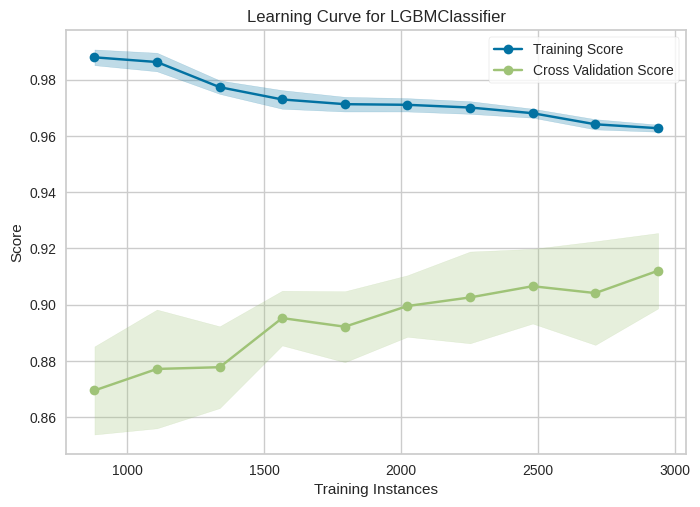

In [41]:
plot_model(final_model, plot = 'learning')

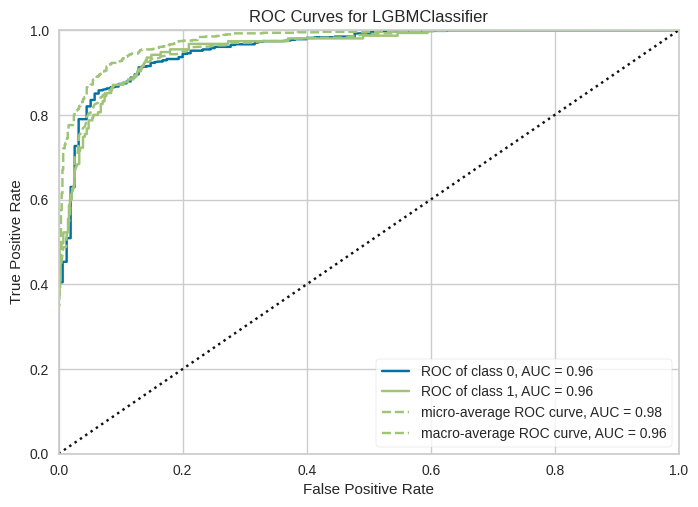

In [42]:
plot_model(final_model, plot = 'auc')

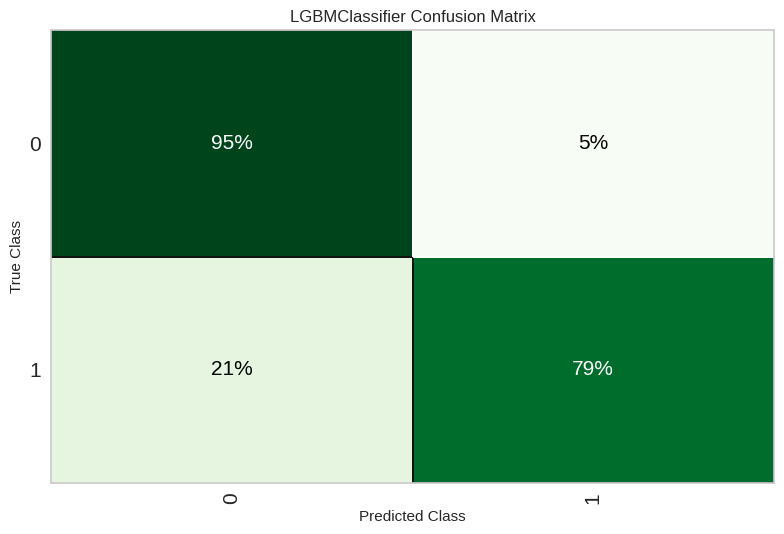

In [43]:
plot_model(final_model, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

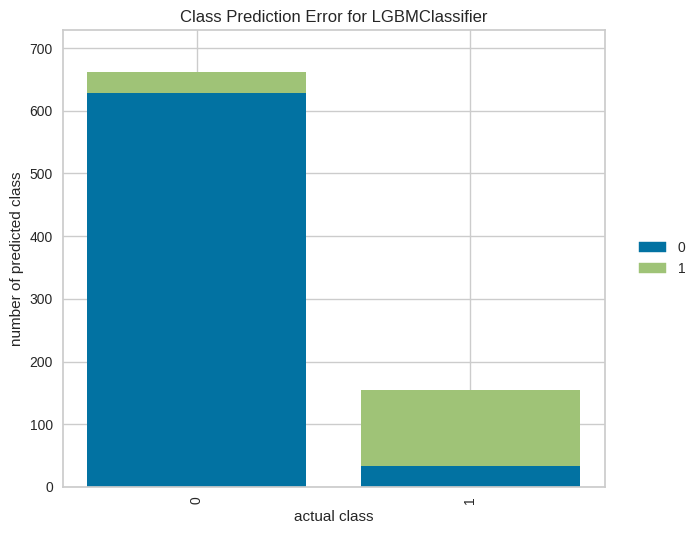

In [44]:
plot_model(final_model, plot = 'error')

### Feature importance plot

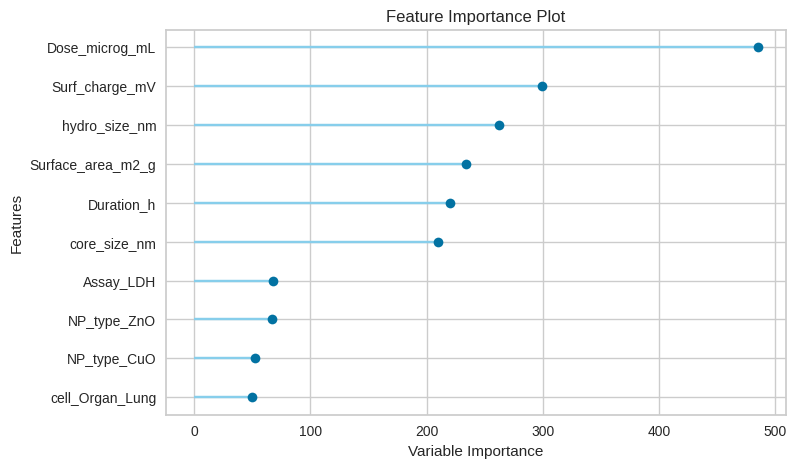

In [45]:
plot_model(final_model, plot = 'feature')

### Save the model to file

In [46]:
save_config('output/models/'+model_name+'_classification_config.cfg')

In [47]:
save_model(final_model, 'output/models/'+model_name+'_classification_model.mdl')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['nanomaterial_group',
                                                        'Coating', 'Cell_name'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='viability_class',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boo...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_rate=0.